In [ ]:
# from LMlstm import SIFT_LSTM
# from loadLabels import load_labels
import torch
import torch.nn as nn
# from loadfeat import load_FeatfromCSV,split_train_val
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import librosa
import glob

In [ ]:
import numpy as np
from scipy.stats import pearsonr


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Model

## Time series Transformer

In [ ]:

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels)
        )

    def forward(self, x):
        # 在 seq_len 维度上进行平均池化
        avg_pooled_tensor = torch.mean(x, dim=1, keepdim=True)  # 输出大小为 (batch_size, 1, input_dim)
        max_pooled_tensor, _ = torch.max(x, dim=1, keepdim=True)  # 输出大小为 (batch_size, 1, input_dim)

        # print(f'{avg_pooled_tensor.shape=}')
        avg_out = self.fc(avg_pooled_tensor.squeeze(1)).unsqueeze(1)
        # print(f'{avg_out.shape=}')
        max_out = self.fc(max_pooled_tensor.squeeze(1)).unsqueeze(1)
        combined = avg_out + max_out
        # print(f'{combined.shape=}')
        attention_weights = torch.sigmoid(combined)
        return attention_weights


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        # Initialize positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input tensor
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class RegressionTransformer(nn.Module):
    def __init__(self, args):
        super(RegressionTransformer, self).__init__()
        self.args = args
        # embed_dim = head_dim * num_heads?
        self.embedding = nn.Linear(args['input_size'], args['d_model'])
        self.channel_attention = ChannelAttention(args['input_size'])
        self.output_fc = nn.Linear(args['input_size'], args['d_model'])
        self.position_encoding = PositionalEncoding(args['d_model'], args['aligned_len'])  # Positional encoding layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=args['d_model'],
            nhead=8,
            dim_feedforward=4 * args['d_model'],
            batch_first=True,
            dropout=0.1,
            device=args['device']
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=args['d_model'],
            nhead=8,
            dropout=0.1,
            dim_feedforward=4 * args['d_model'],
            batch_first=True,
            device=args['device']
        )
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=5)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=5)
        self.fc = nn.Linear(args['d_model'], args['output_size'])
        self.fc1 = nn.Linear(args['aligned_len'] * args['d_model'], args['d_model'])
        self.fc2 = nn.Linear(args['d_model'], args['output_size'])

        self.aligned_len = args['aligned_len']
        self.input_atten_mask = self._generate_square_subsequent_mask(args['aligned_len'])

    def forward(self, x, y, input_mask, tgt_mask):

        input_atten_mask = self.input_atten_mask # shape(batchsize,seqlen,seqlen)

        # x_channel_attention = self.channel_attention(x)  # shape(batchsize, 1, 1, d_model)

        # x = x * x_channel_attention  # 对输入 x 加权

        x = self.embedding(x) # x shape(batchsize,seqlen,d_model)

        x = self.position_encoding(x)  # x shape(batchsize,seqlen,d_model)

        x = self.encoder(src=x, mask=input_atten_mask, src_key_padding_mask=input_mask) # x shape(batchsize,seqlen,d_model)

        # print(f'{y.shape=}_{x.shape=}')
        extend_y=y.expand(-1, -1, self.args['d_model'])
        x = self.decoder(tgt=extend_y, memory=x, tgt_mask=input_atten_mask, memory_mask=input_atten_mask, tgt_is_causal=True, memory_is_causal=True) # x shape(batchsize,seqlen,d_model)

        x = self.fc(x) # x shape(batchsize,seqlen,1)

        return x




    def _generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.bool()
        mask = mask.to(self.args['device'])
        return mask


NameError: name 'nn' is not defined

### example of attention mask

In [ ]:
def generate_square_subsequent_mask(size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.bool()
        return mask

# example of subsequent_mask
size = 6
mask = generate_square_subsequent_mask(size)
print("Test Case 1:")
print(mask)


Test Case 1:
tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])


# Dataset and Dataloader

## Dataset definition

In [ ]:
class SEWADataset(Dataset):
    """
    Dataset definition

    """
    def __init__(self, dataset, labels, maxlen, transform=None):
        self.dataset=dataset
        self.labels = labels  # Added feature_type argument
        self.transform = transform
        self.maxlen=maxlen

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        feature=self.dataset[idx]
        label = self.labels[idx]


         # Convert feature to torch.float32
        feature = torch.tensor(feature, dtype=torch.float32)
        # Convert label to torch.float32
        label = torch.tensor(label, dtype=torch.float32)

        # print(f'{label.shape[0]=}_{self.maxlen=}')
        pad_len = self.maxlen - label.shape[0]
        if pad_len > 0:
            # print(f'before padding{feature.size()=}')
            feature = torch.nn.functional.pad(feature, (0, 0, 0, pad_len), value=0)
            # print(f'after padding{feature.size()=}')
            # print(f'before padding{label.size()=}')
            # label = torch.nn.functional.pad(label, (0,pad_len), value=0)  # Assuming -1 represents padding for labels
            padding_length = self.maxlen - label.shape[0]
            padding = torch.zeros(padding_length, 1)
            label = torch.cat((label, padding), dim=0)

            # print(f'after padding {label.size()=}')

        if pad_len < 0:

            feature = feature[:self.maxlen]
            label = label[:self.maxlen]


        # Generate feature and label masks
        feature_mask = torch.zeros(self.maxlen)
        label_mask = torch.zeros(self.maxlen)
        if pad_len > 0:
            feature_mask[pad_len:] = 1  # Set mask to 1 for padded positions
            label_mask[pad_len:] = 1  # Set mask to 1 for padded positions


        if self.transform:
            feature = self.transform(feature)

        return feature, label,feature_mask,label_mask
    def get_all_labels(self):
            return self.labels

## Dataloader definition

In [ ]:
class SEWAdataLoader(DataLoader):
    """

    """
    def __init__(self, dataset, batch_size=1, shuffle=False, num_workers=0):
        super(SEWAdataLoader, self).__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)



    def __iter__(self):

                for idx in range(0, len(self.dataset), self.batch_size):
                    # get current mini-batch sample
                    batch_data = []
                    for i in range(idx, min(idx + self.batch_size, len(self.dataset))):
                        batch_data.append(self.dataset[i])

                    # Obtain the features and labels of each sample in the current mini-batch
                    batch_inputs = [sample[0] for sample in batch_data]
                    batch_labels = [sample[1] for sample in batch_data]
                    batch_inputs_mask=[sample[2] for sample in batch_data]
                    batch_labels_mask=[sample[3] for sample in batch_data]

                    # print(f'{batch_inputs[0].size()=}_{batch_labels[0].size()=}_{batch_inputs_mask[0].size()=}_{batch_labels_mask[0].size()=}')



                    tensor_inputs = torch.stack(batch_inputs, dim=0)
                    tensor_labels = torch.stack(batch_labels, dim=0)
                    tensor_inputs_mask = torch.stack(batch_inputs_mask, dim=0)
                    tensor_labels_mask = torch.stack(batch_labels_mask, dim=0)
                    # print(f'{tensor_inputs.shape=}')
                    yield tensor_inputs, tensor_labels, tensor_inputs_mask, tensor_labels_mask


# Data Loading

In [ ]:
language='C2'
cls='SA'
Type='Arousal'

## Audio

In [ ]:
# audio
def extract_features_and_labels(folder_path,startwith):
  subfolders = []
  for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    if os.path.isdir(item_path):
      subfolders.append(item_path)

  feat_labdict={}
  for langfolder in subfolders:
    name=langfolder.split('/')[-1]
    print(f'{name=}')
    feat_label={}

    for file in os.listdir(langfolder):
      if file.startswith(startwith):
        file_path = os.path.join(langfolder, file)
        feature=torch.tensor(np.load(file_path+'/features.npy'))
        label=torch.tensor(np.load(file_path+'/labels.npy'))
        feat_label[file]=[feature,label]

    feat_labdict[name]=feat_label
  return feat_labdict

In [ ]:
# Audio single model
input_folder="/content/drive/MyDrive/HuBert_FullLen_PCA"
feat_labdict=extract_features_and_labels(input_folder,cls)
# print(f'{df_C1_PCA=}')
audio_dataset_dict=feat_labdict[language]
audio_dataset=[]
for key,value in audio_dataset_dict.items():
  audio_dataset.append(value)
print(f'{len(audio_dataset)=}')

name='C2'
name='C4'
name='C3'
name='C6'
name='C5'
name='C1'
len(audio_dataset)=32


## Video

In [ ]:
def load_labels(root_dir,language,type,cls,suffix='AV_Aligned'):
    """Loads labels from the directory."""
    labels = {}
    files=[]

    # number of folder dont have a LandMarks
    for filename in os.listdir(root_dir):
        #

        if not f'_{language}_' in filename or not filename.startswith(cls) or not f'{type}' in filename:
          # print(f'{filename=}')
          continue
        file_path = os.path.join(root_dir, filename)
        files.append(file_path)



        # print(f'loading {folder_name=}')
    for csv_file in files:
        file_name_ = os.path.basename(csv_file)
        # filename example: SSL_C2_S055_P109_VC1_004803_005542_Arousal_AV_Aligned
        file_name =file_name_.split('.')[0]
        key="_".join(file_name.split('_')[:-3])
        # print(f'processing {file_name}')
        # key example : 'SSL_C2_S055_P109_VC1_004803_005542'
        # print(f'{key=}')

        label = []

        with open(csv_file, newline='') as csvfile:

            df = pd.read_csv(csv_file)
            label = df[type.lower()].values.reshape(-1, 1)
            labels[key]=label
    return labels

# def test():
#     # Example Usage
#     root_dir = "/content/drive/MyDrive/SEWAv02_label"

#     labels=load_labels(root_dir,language='C1',type='Arousal',cls='SA',suffix='AV_Aligned')

#     print(f'{len(labels)=}')
#     print(f'{labels.keys()=}')
#     ele=labels["SAH_C1_S018_P036_VC1_001394_002328"]
#     print(f'{len(ele)=}')
#     print(f'{type(ele)=}')
#     print(f'{ele=}')


# test()


In [ ]:
def extract_image_feat(folder_path,language,cls):
  features={}
  for folder_name in os.listdir(folder_path):
        #

        if not f'_{language}_' in folder_name or not folder_name.startswith(cls):
          # print(f'{folder_name=}')
          continue

        file_path = os.path.join(folder_path, folder_name)
        feature = torch.load(file_path)

        features[folder_name.split('.')[0]]=feature
  return features


# folder_path="/content/drive/MyDrive/vggpooled"
# language='C1'
# features=extract_image_feat(folder_path,language,'SA')
# print(f'{len(features)=}_{features[0].shape=}')


In [ ]:
# video single model
input_folder="/content/drive/MyDrive/vggpooled"
label_folder="/content/drive/MyDrive/SEWAv02_label"
labels_vi=load_labels(label_folder,language=language,type=Type,cls=cls,suffix='AV_Aligned')
features_vi=extract_image_feat(input_folder,language=language,cls=cls)
print(f'{len(labels_vi)=}_{len(features_vi)=}')

image_dataset=[]
for key in features_vi.keys():
  print(f'{key=}')
  image_dataset.append([features_vi[key],labels_vi[key]])
print(f'{len(image_dataset)=}')

len(labels_vi)=32_len(features_vi)=24
key='SAH_C2_S047_P094_VC1_002101_002718'
key='SAH_C2_S045_P090_VC1_002801_003385'
key='SAH_C2_S049_P097_VC1_003219_004772'
key='SAH_C2_S045_P089_VC1_003626_005086'
key='SAH_C2_S044_P087_VC1_000002_000683'
key='SAH_C2_S050_P100_VC1_002799_003301'
key='SAH_C2_S059_P117_VC1_000601_001353'
key='SAH_C2_S036_P072_VC1_001337_002056'
key='SAH_C2_S044_P088_VC1_000834_001365'
key='SAH_C2_S034_P067_VC1_005252_005735'
key='SAH_C2_S037_P073_VC1_002345_002998'
key='SAL_C2_S050_P099_VC1_003700_004484'
key='SAL_C2_S048_P095_VC1_003085_003710'
key='SAL_C2_S041_P081_VC1_003415_004258'
key='SAL_C2_S044_P087_VC1_004155_004862'
key='SAL_C2_S052_P104_VC1_004088_004607'
key='SAL_C2_S035_P070_VC1_001373_002439'
key='SAL_C2_S038_P076_VC1_001881_002782'
key='SAL_C2_S052_P103_VC1_003842_004770'
key='SAL_C2_S038_P075_VC1_004032_005262'
key='SAL_C2_S042_P083_VC1_001958_003364'
key='SAL_C2_S199_P398_VC1_000467_002764'
key='SAL_C2_S197_P393_VC1_000787_002868'
key='SAL_C2_S195_P3

## Video-Audio

In [ ]:
# video-audio model
input_folder="/content/drive/MyDrive/vggpooled"
label_folder="/content/drive/MyDrive/SEWAv02_label"
# labels_fu=load_labels(label_folder,language=language,type='Arousal',cls='SA',suffix='AV_Aligned')
# image_features=extract_image_feat(input_folder,language=language,cls='SA')
# print(f'{len(labels_vi)=}_{len(image_features)=}')


input_folder="/content/drive/MyDrive/HuBert_FullLen_PCA"
feat_labdict_fu=extract_features_and_labels(input_folder,cls)
audio_dataset_dict_fu=feat_labdict_fu[language]

fuse_dataset=[]
aligned_len=749
for key in features_vi.keys():
  print(f'{key=}')
  image_feature=features_vi[key]
  print(f'{image_feature.shape=}')
  audio_feature=audio_dataset_dict_fu[key][0]
  print(f'{audio_feature.shape=}')
  croped_len=min(audio_feature.shape[0],aligned_len)

  image_feature=image_feature[:croped_len]
  audio_feature=audio_feature[:croped_len]
  print(f'aligned {image_feature.shape=}')
  fused_feature = torch.cat((image_feature, audio_feature), dim=1)
  print(f'{fused_feature.shape=}')
  fuse_dataset.append([fused_feature,labels_vi[key][:croped_len]])


name='C2'
name='C4'
name='C3'
name='C6'
name='C5'
name='C1'
key='SAH_C2_S047_P094_VC1_002101_002718'
image_feature.shape=torch.Size([618, 512])
audio_feature.shape=torch.Size([617, 128])
aligned image_feature.shape=torch.Size([617, 512])
fused_feature.shape=torch.Size([617, 640])
key='SAH_C2_S045_P090_VC1_002801_003385'
image_feature.shape=torch.Size([585, 512])
audio_feature.shape=torch.Size([584, 128])
aligned image_feature.shape=torch.Size([584, 512])
fused_feature.shape=torch.Size([584, 640])
key='SAH_C2_S049_P097_VC1_003219_004772'
image_feature.shape=torch.Size([750, 512])
audio_feature.shape=torch.Size([1553, 128])
aligned image_feature.shape=torch.Size([749, 512])
fused_feature.shape=torch.Size([749, 640])
key='SAH_C2_S045_P089_VC1_003626_005086'
image_feature.shape=torch.Size([750, 512])
audio_feature.shape=torch.Size([1460, 128])
aligned image_feature.shape=torch.Size([749, 512])
fused_feature.shape=torch.Size([749, 640])
key='SAH_C2_S044_P087_VC1_000002_000683'
image_feature

## Splite training and validation set

In [ ]:
def split_train_val(dataset, test_size=0.2, random_state=None):
    """
    Split the dataset into training and validation sets

    Parameters:
        dataset: The dataset to be split
        test_size: The proportion of the dataset to include in the validation set, default is 0.2
        random_state: The random seed for reproducibility, default is None

    Returns:
        train_dataset: The training set
        val_dataset: The validation set
    """
    # Get the length of the dataset
    dataset_length = len(dataset)

    # Calculate the size of the validation set
    val_size = int(test_size * dataset_length)

    # Split the dataset using the train_test_split function from sklearn
    train_dataset, val_dataset = train_test_split(dataset, test_size=test_size, random_state=random_state)

    return train_dataset, val_dataset



## Other processing

In [ ]:

def trans_to_tensor(train_data,val_data):
  train_inputs=[]
  train_labels=[]
  val_inputs=[]
  val_labels=[]
  for it in train_data:
    train_inputs.append(torch.tensor(it[0]))
    # print(f'{it[1].ndim=}')
    if it[1].ndim<2:
      train_labels.append(torch.tensor(it[1]).unsqueeze(1))
    else:
      train_labels.append(torch.tensor(it[1]))
  print(f'{train_inputs[0].shape=}_{train_labels[0].shape=}')
  # train_inputs=torch.stack(train_inputs, dim=0)
  # train_labels=torch.stack(train_labels, dim=0)

  # print(f'{train_inputs.shape=}_{train_labels.shape=}')


  for it in val_data:
    val_inputs.append(torch.tensor(it[0]))
    if it[1].ndim<2:
      val_labels.append(torch.tensor(it[1]).unsqueeze(1))
    else:
      val_labels.append(torch.tensor(it[1]))
  print(f'{train_inputs[0].shape=}_{train_labels[0].shape=}')

  print(f'{val_inputs[0].shape=}_{val_labels[0].shape=}')
  return train_inputs,train_labels,val_inputs,val_labels


# Training module

## loss function

In [ ]:
import torch

def CCCloss(predictions,targets,effective_lengths):
     # 计算均值
    # 计算均值
    mean_pred = torch.sum(predictions, dim=(1, 2), keepdim=True) / effective_lengths.unsqueeze(1).unsqueeze(2)
    mean_true = torch.sum(targets, dim=(1, 2), keepdim=True) / effective_lengths.unsqueeze(1).unsqueeze(2)

    # 计算方差
    var_pred = torch.sum((predictions - mean_pred)**2, dim=(1, 2), keepdim=True) / effective_lengths.unsqueeze(1).unsqueeze(2)
    var_true = torch.sum((targets - mean_true)**2, dim=(1, 2), keepdim=True) / effective_lengths.unsqueeze(1).unsqueeze(2)

    # 计算协方差
    cov = torch.sum((predictions - mean_pred) * (targets - mean_true), dim=(1, 2), keepdim=True) / effective_lengths.unsqueeze(1).unsqueeze(2)

    # 计算CCC
    ccc = 2 * cov / (var_pred + var_true + (mean_pred - mean_true)**2)
    ccc = torch.mean(ccc)
    return 1 - torch.abs(ccc)

def test():
 # 示例数据
  batch_size = 2
  seq_len = 3
  input_dim = 2

  # 生成随机特征和标签
  features = torch.rand(batch_size, seq_len, input_dim)
  labels = torch.rand(batch_size, seq_len, 1)

  # 假设有效长度
  effective_lengths = torch.tensor([2, 3])

  # 计算CCC
  ccc_score = CCCloss(features, labels, effective_lengths)

  print("批次数据的CCC:", ccc_score)
# test()


In [ ]:

class RmseCCCLoss(nn.Module):
    def __init__(self,wRMSE,wCCC):
        super(RmseCCCLoss, self).__init__()
        self.wRMSE=wRMSE
        self.wCCC=wCCC
    def forward(self, input_features, masked_outputs, masked_labels,effective_lengths):
        criterion1 = nn.MSELoss(reduction='none')
        loss1 = criterion1(masked_outputs, masked_labels)
        loss1 = torch.sum(loss1, dim=1) / effective_lengths
        loss1 = torch.mean(loss1)
        loss1 = torch.sqrt(loss1)

        loss2 = CCCloss(input_features,masked_outputs,effective_lengths)
        loss = self.wRMSE*loss1+self.wCCC*loss2
        return loss,loss1,loss2


In [ ]:

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs,device):
    for epoch in range(num_epochs):
        # --------------Training -----------------
        model = model.to(device)
        model.train()
        for batch_inputs, batch_labels,batch_inputs_mask,batch_labels_mask in train_loader:
            # shift the label for 1 unit

            # Assume batch_labels is a tensor of shape (batch_size, sequence_length, 1)
            batch_size, sequence_length, _ = batch_labels.size()

            # Create a tensor filled with zeros as the result
            batch_labels_shift = torch.zeros(batch_size, sequence_length, 1, dtype=batch_labels.dtype, device=batch_labels.device)

            # Shift the data in batch_labels by one unit to the right, fill the leftmost position with 0, and discard the rightmost one
            batch_labels_shift[:, 1:, :] = batch_labels[:, :-1, :]

            # Ensure that batch_labels_shift and batch_labels are aligned
            batch_labels_shift[:, 0, :] = 0  # Fill the leftmost position with 0


            # Passing input data x and labels y into the model
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_labels_shift = batch_labels.to(device)
            batch_inputs_mask = batch_inputs_mask.to(device)
            batch_labels_mask = batch_labels_mask.to(device)
            outputs = model(batch_inputs,batch_labels_shift,batch_inputs_mask,batch_labels_mask)


            flipped_labels_mask = (batch_labels_mask == 0)

            masked_outputs = outputs * flipped_labels_mask.float().unsqueeze(-1)

            effective_lengths = torch.sum(flipped_labels_mask, dim=1)  # Sum up along the second dimension to obtain the effective length of each sample.



            masked_labels = batch_labels * flipped_labels_mask.float().unsqueeze(-1)

            loss,lossrmse,lossccc = criterion(batch_inputs,masked_outputs, masked_labels,effective_lengths)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          # Printing the loss for the current iteration

        train_loss=loss.item()

        # Evaluating the model's performance
        model.eval()
        total_loss = 0.0
        total_lossrmse = 0.0
        total_lossccc = 0.0
        total_batch = 0

        # --------------validation each epoch-----------------
        for batch_inputs, batch_labels,batch_inputs_mask,batch_labels_mask in test_loader:
            # shift the label for 1 unit

              # Assume batch_labels is a tensor of shape (batch_size, sequence_length, 1)
              batch_size, sequence_length, _ = batch_labels.size()

              # Create a tensor filled with zeros as the result
              batch_labels_shift = torch.zeros(batch_size, sequence_length, 1, dtype=batch_labels.dtype, device=batch_labels.device)

              # Shift the data in batch_labels by one unit to the right, fill the leftmost position with 0, and discard the rightmost one
              batch_labels_shift[:, 1:, :] = batch_labels[:, :-1, :]

              # Ensure that batch_labels_shift and batch_labels are aligned
              batch_labels_shift[:, 0, :] = 0  # Fill the leftmost position with 0


            # Passing input data x and labels y into the model
              batch_inputs = batch_inputs.to(device)
              batch_labels = batch_labels.to(device)
              batch_labels_shift = batch_labels.to(device)
              batch_inputs_mask = batch_inputs_mask.to(device)
              batch_labels_mask = batch_labels_mask.to(device)
              outputs = model(batch_inputs,batch_labels_shift,batch_inputs_mask,batch_labels_mask)


              flipped_labels_mask = (batch_labels_mask == 0)

              masked_outputs = outputs * flipped_labels_mask.float().unsqueeze(-1)

              effective_lengths = torch.sum(flipped_labels_mask, dim=1)  # Sum up along the second dimension to obtain the effective length of each sample.
              masked_labels = batch_labels * flipped_labels_mask.float().unsqueeze(-1)
              loss,lossrmse,lossccc = criterion(batch_inputs,masked_outputs, masked_labels,effective_lengths)

              print(f'{lossccc=}')
              total_loss+=loss
              total_lossrmse+=lossrmse
              total_lossccc+=lossccc
              total_batch+=1





        total_loss=total_loss/total_batch
        total_lossrmse=total_lossrmse/total_batch
        total_lossccc=total_lossccc/total_batch
        print(f'Epoch [{epoch+1}/{num_epochs}], TrainLoss: {train_loss:.4f},TestLoss: {total_loss:.4f},TestRMSELoss: {total_lossrmse:.4f},TestCCCLoss: {total_lossccc:.4f}')

    # --------------validation -----------------
    all_predicted = []
    all_labels = []
    for batch_inputs, batch_labels,batch_inputs_mask,batch_labels_mask in test_loader:

              # Assume batch_labels is a tensor of shape (batch_size, sequence_length, 1)
              batch_size, sequence_length, _ = batch_labels.size()

              # Create a tensor filled with zeros as the result
              batch_labels_shift = torch.zeros(batch_size, sequence_length, 1, dtype=batch_labels.dtype, device=batch_labels.device)

              # Shift the data in batch_labels by one unit to the right, fill the leftmost position with 0, and discard the rightmost one
              batch_labels_shift[:, 1:, :] = batch_labels[:, :-1, :]

              # Ensure that batch_labels_shift and batch_labels are aligned
              batch_labels_shift[:, 0, :] = 0  # Fill the leftmost position with 0

            # Passing input data x and labels y into the model
              batch_inputs = batch_inputs.to(device)
              batch_labels = batch_labels.to(device)
              batch_labels_shift = batch_labels.to(device)
              batch_inputs_mask = batch_inputs_mask.to(device)
              batch_labels_mask = batch_labels_mask.to(device)
              outputs = model(batch_inputs,batch_labels_shift,batch_inputs_mask,batch_labels_mask)


              flipped_labels_mask = (batch_labels_mask == 0)

              masked_outputs = outputs * flipped_labels_mask.float().unsqueeze(-1)

              masked_labels = batch_labels * flipped_labels_mask.float().unsqueeze(-1)

              all_predicted.append(masked_outputs)
              all_labels.append(masked_labels)


    import matplotlib.pyplot as plt

    # Plot a line graph for one sample
    predata = all_predicted[0][0].tolist()
    labeldata = all_labels[0][0].tolist()
    x=list(range(1, len(predata) + 1))
    # Plot a line graph for prediction
    plt.plot(x, predata)
    plt.xlabel('Length')
    plt.ylabel('Value')
    plt.title('Predicted')
    plt.show()
    # Plot a line graph for GT
    plt.plot(x, labeldata)
    plt.xlabel('Length')
    plt.ylabel('Value')
    plt.title('Ground True')
    plt.show()


## Training

### Audio

finish split_train_val dataset
Training set length: 25
Validation set length: 7
train_inputs[0].shape=torch.Size([584, 128])_train_labels[0].shape=torch.Size([584, 1])
train_inputs[0].shape=torch.Size([584, 128])_train_labels[0].shape=torch.Size([584, 1])
val_inputs[0].shape=torch.Size([653, 128])_val_labels[0].shape=torch.Size([653, 1])
len(train_loader)=4
len(test_loader)=1


<ipython-input-19-1305ba55557c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs.append(torch.tensor(it[0]))
<ipython-input-19-1305ba55557c>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels.append(torch.tensor(it[1]).unsqueeze(1))
<ipython-input-19-1305ba55557c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs.append(torch.tensor(it[0]))
<ipython-input-19-1305ba55557c>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

lossccc=tensor(0.9991, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [1/50], TrainLoss: 0.4081,TestLoss: 1.5501,TestRMSELoss: 1.5501,TestCCCLoss: 0.9991
lossccc=tensor(0.9998, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [2/50], TrainLoss: 0.3548,TestLoss: 0.8168,TestRMSELoss: 0.8168,TestCCCLoss: 0.9998
lossccc=tensor(0.9998, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [3/50], TrainLoss: 0.7294,TestLoss: 0.7092,TestRMSELoss: 0.7092,TestCCCLoss: 0.9998
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [4/50], TrainLoss: 0.4624,TestLoss: 0.6030,TestRMSELoss: 0.6030,TestCCCLoss: 1.0000
lossccc=tensor(0.9999, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [5/50], TrainLoss: 0.0925,TestLoss: 0.7880,TestRMSELoss: 0.7880,TestCCCLoss: 0.9999
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [6/50], TrainLoss: 0.2619,TestLoss: 0.5683,TestRMSELoss: 0.5683,TestCCCLoss: 1.0000
lossccc=tensor(0.9999, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch

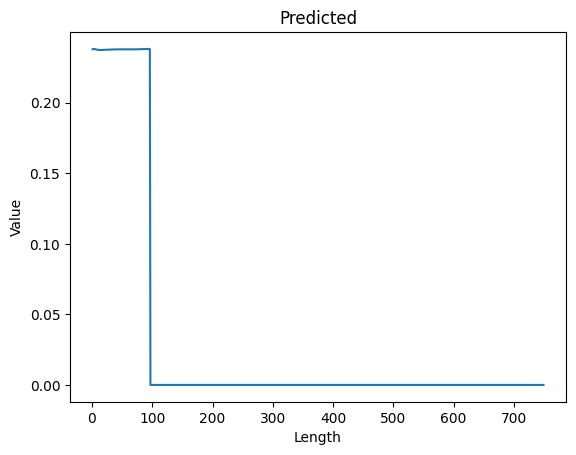

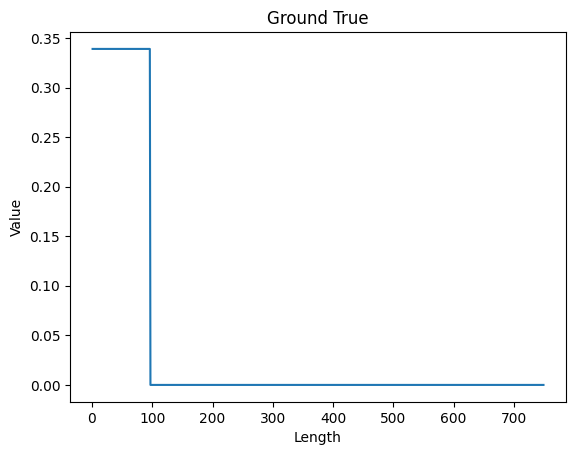

In [ ]:
#

args = {
    'input_size': 128,     # Dimensionality of feature vectors per frame (audio)
    'd_model': 64,        # Transformer hidden units
    'num_layers': 4,      # Number of Encoder/Decoder layers
    'output_size': 1,     # Output dimensionality
    'device': 'cuda',      # Training device
    'aligned_len': 749,  # Aligned sequence length
    'num_epochs': 50,      # Number of training epochs
    'batch_size':8
}

# Initialize the model
model = RegressionTransformer(args)
# Define the loss function and optimizer
# criterion = nn.MSELoss(reduction='none')
criterion = RmseCCCLoss(wRMSE=1,wCCC=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_data_au, val_data_au = split_train_val(audio_dataset,random_state=42)
print('finish split_train_val dataset')
    # Output the lengths of training and validation sets
print("Training set length:", len(train_data_au))
print("Validation set length:", len(val_data_au))

train_inputs_au,train_labels_au,val_inputs_au,val_labels_au=trans_to_tensor(train_data_au,val_data_au)

traindataset = SEWADataset(dataset=train_inputs_au, labels=train_labels_au, maxlen=args['aligned_len'])
train_loader = SEWAdataLoader(traindataset, args['batch_size'])
print(f'{len(train_loader)=}')
testdataset = SEWADataset(dataset=val_inputs_au, labels=val_labels_au, maxlen=args['aligned_len'])
test_loader = SEWAdataLoader(testdataset, args['batch_size'])
print(f'{len(test_loader)=}')
train_model(model, train_loader, test_loader, criterion, optimizer, args['num_epochs'], args['device'])


### Video

finish split_train_val dataset
Training set length: 19
Validation set length: 5
train_inputs[0].shape=torch.Size([484, 512])_train_labels[0].shape=torch.Size([484, 1])
train_inputs[0].shape=torch.Size([484, 512])_train_labels[0].shape=torch.Size([484, 1])
val_inputs[0].shape=torch.Size([532, 512])_val_labels[0].shape=torch.Size([532, 1])
len(train_loader)=3
len(test_loader)=1


<ipython-input-19-1305ba55557c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs.append(torch.tensor(it[0]))
<ipython-input-19-1305ba55557c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs.append(torch.tensor(it[0]))
<ipython-input-84-bacae5332154>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


lossccc=tensor(0.9999, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [1/50], TrainLoss: 1.7226,TestLoss: 0.3593,TestRMSELoss: 0.2881,TestCCCLoss: 0.9999
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [2/50], TrainLoss: 0.9052,TestLoss: 0.6368,TestRMSELoss: 0.5965,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [3/50], TrainLoss: 0.5038,TestLoss: 0.4218,TestRMSELoss: 0.3575,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [4/50], TrainLoss: 0.5031,TestLoss: 0.5836,TestRMSELoss: 0.5373,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [5/50], TrainLoss: 0.4547,TestLoss: 0.4634,TestRMSELoss: 0.4038,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [6/50], TrainLoss: 0.3853,TestLoss: 0.4230,TestRMSELoss: 0.3589,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch

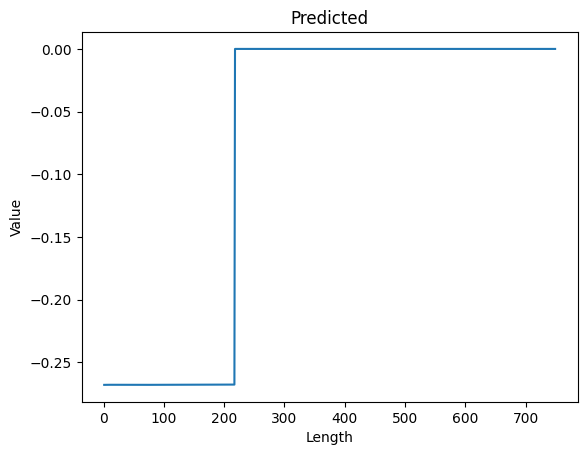

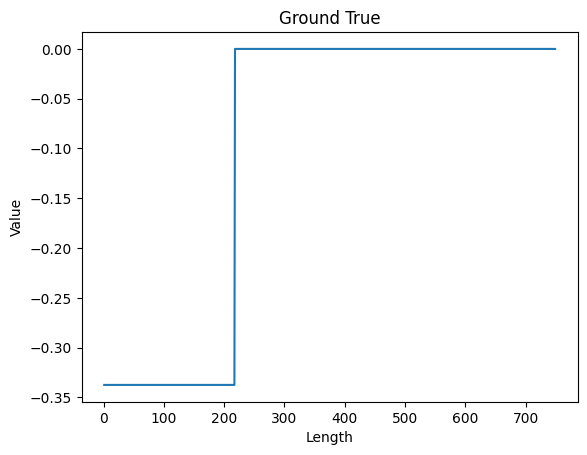

In [ ]:
#


args = {
    'input_size': 512,     # Dimensionality of feature vectors per frame (audio)
    'd_model': 64,        # Transformer hidden units
    'num_layers': 4,      # Number of Encoder/Decoder layers
    'output_size': 1,     # Output dimensionality
    'device': 'cuda',      # Training device
    'aligned_len': 749,  # Aligned sequence length
    'num_epochs': 50,      # Number of training epochs
    'batch_size':8
}

# Initialize the model
model = RegressionTransformer(args)


# Define the loss function and optimizer
# criterion = nn.MSELoss(reduction='none')
criterion = RmseCCCLoss(wRMSE=0.9,wCCC=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_data_vi, val_data_vi = split_train_val(image_dataset,random_state=42)
print('finish split_train_val dataset')
    # Output the lengths of training and validation sets
print("Training set length:", len(train_data_vi))
print("Validation set length:", len(val_data_vi))
train_inputs_vi,train_labels_vi,val_inputs_vi,val_labels_vi=trans_to_tensor(train_data_vi,val_data_vi)


traindataset = SEWADataset(dataset=train_inputs_vi, labels=train_labels_vi, maxlen=args['aligned_len'])
train_loader = SEWAdataLoader(traindataset, args['batch_size'])
print(f'{len(train_loader)=}')
testdataset = SEWADataset(dataset=val_inputs_vi, labels=val_labels_vi, maxlen=args['aligned_len'])
test_loader = SEWAdataLoader(testdataset, args['batch_size'])
print(f'{len(test_loader)=}')
train_model(model, train_loader, test_loader, criterion, optimizer, args['num_epochs'], args['device'])


### Audio-Video

finish split_train_val dataset
Training set length: 19
Validation set length: 5
train_inputs[0].shape=torch.Size([483, 640])_train_labels[0].shape=torch.Size([483, 1])
train_inputs[0].shape=torch.Size([483, 640])_train_labels[0].shape=torch.Size([483, 1])
val_inputs[0].shape=torch.Size([531, 640])_val_labels[0].shape=torch.Size([531, 1])
len(train_loader)=3
len(test_loader)=1


<ipython-input-19-1305ba55557c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs.append(torch.tensor(it[0]))
<ipython-input-19-1305ba55557c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs.append(torch.tensor(it[0]))
<ipython-input-84-bacae5332154>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


lossccc=tensor(0.9999, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [1/50], TrainLoss: 1.5879,TestLoss: 0.6398,TestRMSELoss: 0.5998,TestCCCLoss: 0.9999
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [2/50], TrainLoss: 1.2151,TestLoss: 0.4296,TestRMSELoss: 0.3662,TestCCCLoss: 1.0000
lossccc=tensor(0.9999, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [3/50], TrainLoss: 0.8593,TestLoss: 0.8574,TestRMSELoss: 0.8416,TestCCCLoss: 0.9999
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [4/50], TrainLoss: 0.6859,TestLoss: 0.5476,TestRMSELoss: 0.4973,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [5/50], TrainLoss: 0.5607,TestLoss: 0.3989,TestRMSELoss: 0.3322,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch [6/50], TrainLoss: 0.4565,TestLoss: 0.4870,TestRMSELoss: 0.4300,TestCCCLoss: 1.0000
lossccc=tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)
Epoch

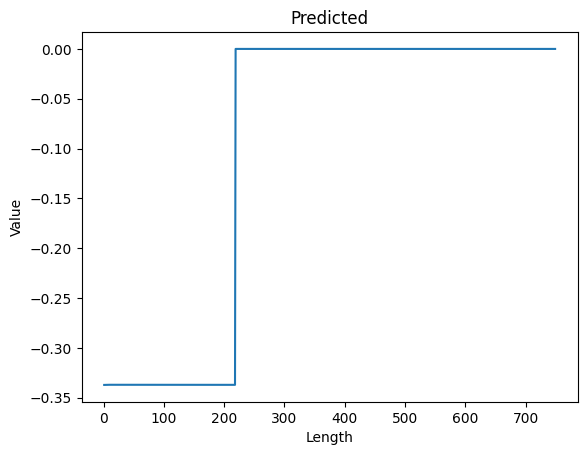

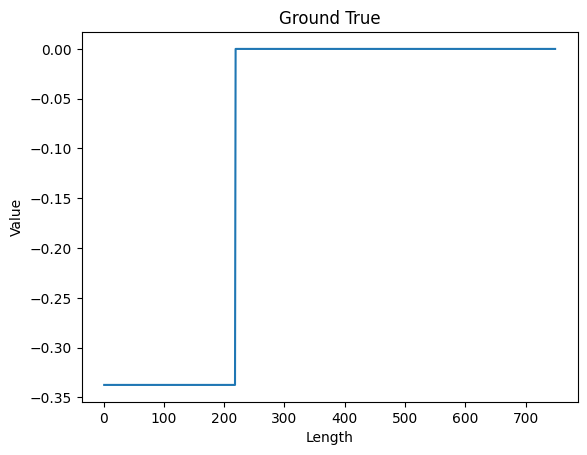

In [ ]:
#

args = {
    'input_size': 640,     # Dimensionality of feature vectors per frame (audio)
    'd_model': 64,        # Transformer hidden units
    'num_layers': 4,      # Number of Encoder/Decoder layers
    'output_size': 1,     # Output dimensionality
    'device': 'cuda',      # Training device
    'aligned_len': 749,  # Aligned sequence length
    'num_epochs': 50,      # Number of training epochs
    'batch_size':8
}

# Initialize the model
model = RegressionTransformer(args)
# Define the loss function and optimizer
# criterion = nn.MSELoss(reduction='none')
criterion = RmseCCCLoss(wRMSE=0.9,wCCC=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_data_av, val_data_av = split_train_val(fuse_dataset,random_state=42)
print('finish split_train_val dataset')
    # Output the lengths of training and validation sets
print("Training set length:", len(train_data_av))
print("Validation set length:", len(val_data_av))

train_inputs_av,train_labels_av,val_inputs_av,val_labels_av=trans_to_tensor(train_data_av,val_data_av)

traindataset = SEWADataset(dataset=train_inputs_av, labels=train_labels_av, maxlen=args['aligned_len'])
train_loader = SEWAdataLoader(traindataset, args['batch_size'])
print(f'{len(train_loader)=}')
testdataset = SEWADataset(dataset=val_inputs_av, labels=val_labels_av, maxlen=args['aligned_len'])
test_loader = SEWAdataLoader(testdataset, args['batch_size'])
print(f'{len(test_loader)=}')
train_model(model, train_loader, test_loader, criterion, optimizer, args['num_epochs'], args['device'])
